In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import json
from os.path import expanduser

In [44]:
experiment_name = 'P3856'
feature_detection_method = 'pasef'

IDENTIFICATIONS_WITH_CS_DIR = '{}/P3856-results-cs-true-fmdw-true-2021-04-22-16-56-39/identifications-pasef'.format(expanduser("~"))
IDENTIFICATIONS_WITH_CS_FILE = '{}/exp-{}-identifications-{}-recalibrated.pkl'.format(IDENTIFICATIONS_WITH_CS_DIR, experiment_name, feature_detection_method)

In [45]:
IDENTIFICATIONS_WITH_CS_FILE

'/home/daryl/P3856-results-cs-true-fmdw-true-2021-04-22-16-56-39/identifications-pasef/exp-P3856-identifications-pasef-recalibrated.pkl'

In [46]:
MAXIMUM_Q_VALUE = 0.01

#### identifications with correction for saturation

In [47]:
# load the identifications that had saturated points in the mono
with open(IDENTIFICATIONS_WITH_CS_FILE, 'rb') as handle:
    d = pickle.load(handle)
identifications_with_cs_df = d['identifications_df']
identifications_with_cs_df = identifications_with_cs_df[(identifications_with_cs_df['percolator q-value'] <= MAXIMUM_Q_VALUE)]

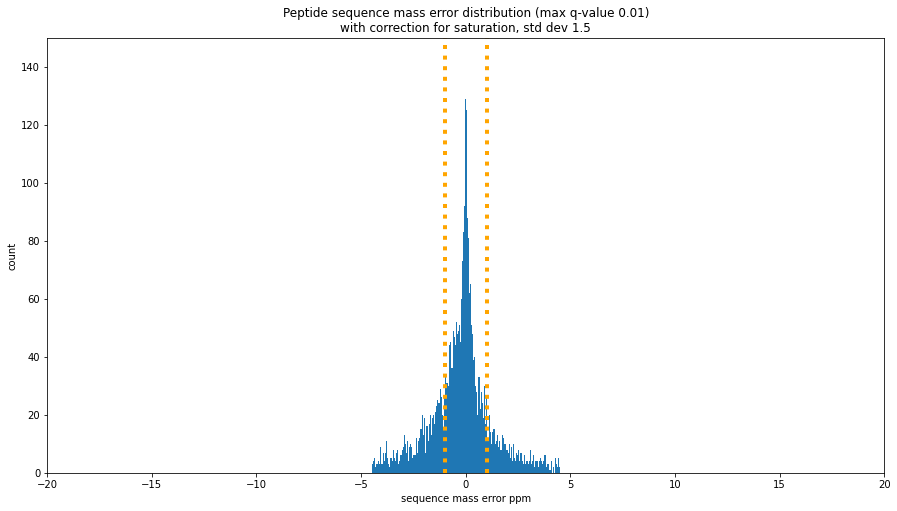

In [48]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide sequence mass error distribution (max q-value {})\nwith correction for saturation, std dev {}'.format(MAXIMUM_Q_VALUE, round(identifications_with_cs_df.mass_accuracy_ppm.std(),1)))

bins = 300
hist, bins, _ = plt.hist(identifications_with_cs_df.mass_accuracy_ppm, bins=bins)
plt.xlabel('sequence mass error ppm')
plt.ylabel('count')

plt.xlim((-20,20))
plt.ylim((0,150))

plt.axvline(x=+1, linestyle=':', linewidth=4, color='orange')
plt.axvline(x=-1, linestyle=':', linewidth=4, color='orange')

plt.show()

#### identifications without correction for saturation

In [7]:
IDENTIFICATIONS_DIR = '{}/P3856-results-cs-false-fmdw-true-2021-04-23-02-17-16/identifications-pasef'.format(expanduser("~"))
IDENTIFICATIONS_FILE = '{}/exp-{}-identifications-{}-recalibrated.pkl'.format(IDENTIFICATIONS_DIR, experiment_name, feature_detection_method)

In [8]:
# load the identifications that had saturated points in the mono
with open(IDENTIFICATIONS_FILE, 'rb') as handle:
    d = pickle.load(handle)
identifications_without_cs_df = d['identifications_df']
identifications_without_cs_df = identifications_without_cs_df[(identifications_without_cs_df['percolator q-value'] <= MAXIMUM_Q_VALUE)]

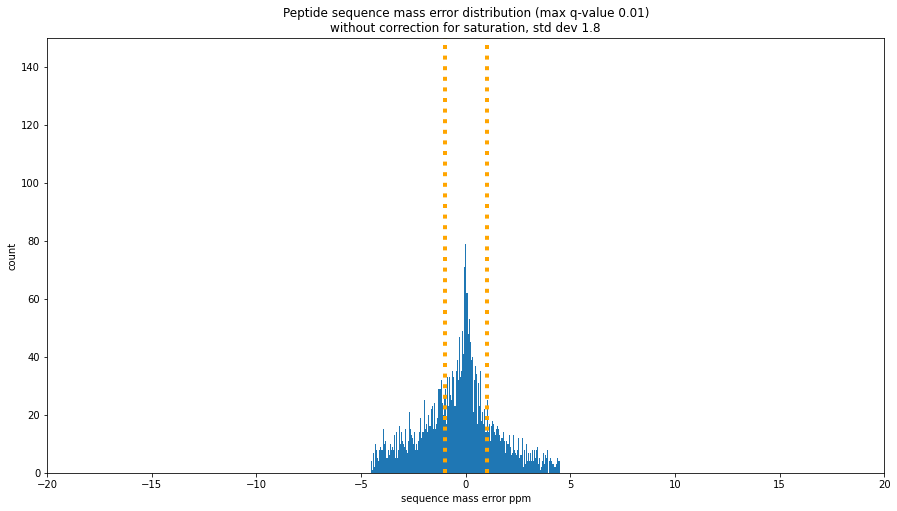

In [38]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide sequence mass error distribution (max q-value {})\nwithout correction for saturation, std dev {}'.format(MAXIMUM_Q_VALUE, round(identifications_without_cs_df.mass_accuracy_ppm.std(),1)))

bins = 300
hist, bins, _ = plt.hist(identifications_without_cs_df.mass_accuracy_ppm, bins=bins)
plt.xlabel('sequence mass error ppm')
plt.ylabel('count')

plt.xlim((-20,20))
plt.ylim((0,150))

plt.axvline(x=+1, linestyle=':', linewidth=4, color='orange')
plt.axvline(x=-1, linestyle=':', linewidth=4, color='orange')

plt.show()

#### unique identifications found with and without saturation correction

In [10]:
sequences_l = []
for group_name,group_df in identifications_with_cs_df.groupby(['sequence','charge'], as_index=False):
    sequence = group_name[0]
    charge = group_name[1]
    percolator_score = group_df['percolator score'].max()
    q_value = group_df['percolator q-value'].min()
    sequences_l.append({'sequence':sequence, 'charge':charge, 'score':percolator_score, 'q_value':q_value})
sequences_with_cs_df = pd.DataFrame(sequences_l)

In [11]:
sequences_l = []
for group_name,group_df in identifications_without_cs_df.groupby(['sequence','charge'], as_index=False):
    sequence = group_name[0]
    charge = group_name[1]
    percolator_score = group_df['percolator score'].max()
    q_value = group_df['percolator q-value'].min()
    sequences_l.append({'sequence':sequence, 'charge':charge, 'score':percolator_score, 'q_value':q_value})
sequences_without_cs_df = pd.DataFrame(sequences_l)

In [12]:
combined_df = pd.merge(sequences_with_cs_df, sequences_without_cs_df, how='inner', left_on=['sequence','charge'], right_on=['sequence','charge'], suffixes=['_with_cs','_without_cs'])


In [13]:
combined_df['q_value_ratio'] = combined_df.q_value_with_cs / combined_df.q_value_without_cs
combined_df['score_ratio'] = combined_df.score_with_cs / combined_df.score_without_cs

In [14]:
combined_df.sample(n=5)

,sequence,charge,score_with_cs,q_value_with_cs,score_without_cs,q_value_without_cs,q_value_ratio,score_ratio
777,ENIVEAIIHSPELIR,2,0.650721,0.000249,0.774462,0.000284,0.877769,0.840223
3237,TQTVCNFTDGALVQHQEWDGK,3,0.899544,0.000249,0.989314,0.000284,0.877769,0.909260
2559,QAQIEVVPSASALIIK,2,0.601256,0.000249,0.706509,0.000284,0.877769,0.851024
3387,VGAIPANALDDGQWSQGLISAAR,2,1.034474,0.000249,1.119180,0.000284,0.877769,0.924315
1054,FYCDYCDTYLTHDSPSVR,2,0.864672,0.000249,0.879206,0.000284,0.877769,0.983469


In [15]:
combined_df.loc[combined_df.score_ratio.idxmax()]

sequence              GGGLFLLAGPPASVETLGPR
charge                                   2
score_with_cs                     0.855378
q_value_with_cs                0.000248942
score_without_cs                 0.0171263
q_value_without_cs              0.00727953
q_value_ratio                    0.0341975
score_ratio                        49.9451
Name: 1135, dtype: object

#### dynamic range comparison

In [18]:
s1 = identifications_with_cs_df.mono_intensity_adjustment_outcome.value_counts(normalize=False).rename('counts', inplace=True)
s2 = round(identifications_with_cs_df.mono_intensity_adjustment_outcome.value_counts(normalize=True)*100,1).rename('%', inplace=True)
pd.concat([s1, s2], axis=1)

,counts,%
monoisotopic_not_saturated,4839,94.0
monoisotopic_saturated_adjusted,307,6.0
no_nonsaturated_isotopes,3,0.1
could_not_calculate_phr,1,0.0


In [19]:
identifications_with_cs_df = identifications_with_cs_df.copy()
identifications_with_cs_df['intensity_log'] = np.log10(identifications_with_cs_df.feature_intensity)

identifications_without_cs_df = identifications_without_cs_df.copy()
identifications_without_cs_df['intensity_log'] = np.log10(identifications_without_cs_df.feature_intensity)

identifications_with_cs_df['method'] = 'corrected for saturation'
identifications_without_cs_df['method'] = 'not corrected for saturation'
idents_df = pd.concat([identifications_with_cs_df,identifications_without_cs_df], axis=0, sort=False)


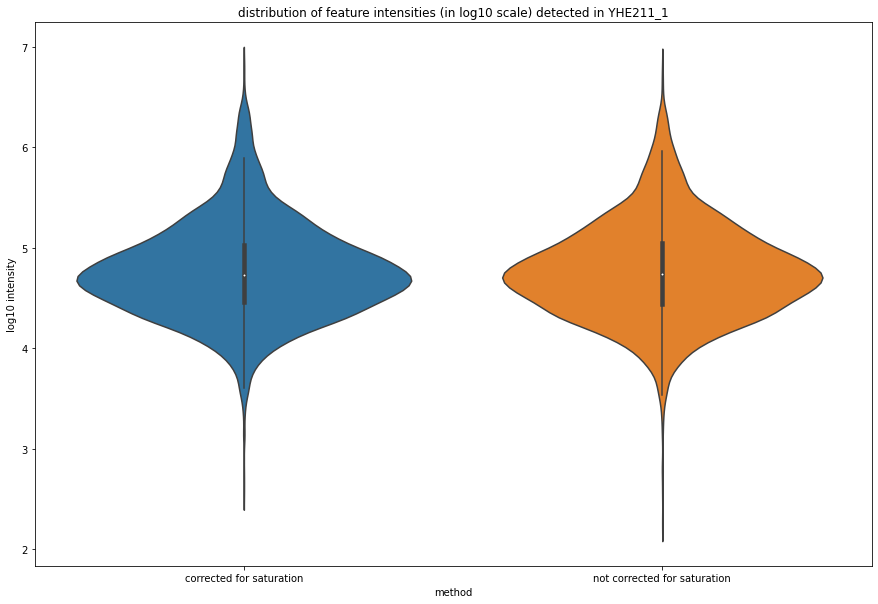

In [20]:
plt.figure(figsize=(15,10))
ax = sns.violinplot(x=idents_df.method, y=idents_df.intensity_log)
_ = plt.ylabel("log10 intensity")
_ = plt.title('distribution of feature intensities (in log10 scale) detected in YHE211_1')

In [21]:
dynamic_range_with_cs = identifications_with_cs_df.intensity_log.max() - identifications_with_cs_df.intensity_log.min()
dynamic_range_without_cs = identifications_without_cs_df.intensity_log.max() - identifications_without_cs_df.intensity_log.min()
print('orders of magnitude with cs: {}, without cs: {}'.format(round(dynamic_range_with_cs,2), round(dynamic_range_without_cs,2)))

orders of magnitude with cs: 4.26, without cs: 4.54


#### for those identifications with an adjusted intensity, what would the intensity range have been without correction?

In [22]:
adj_with_cs_df = identifications_with_cs_df[identifications_with_cs_df.mono_intensity_adjustment_outcome == 'monoisotopic_saturated_adjusted']


In [50]:
adj_l = []
for row in adj_with_cs_df.itertuples():
    cs_intensity = row.mono_intensity_with_saturation_correction if (row.mono_intensity_with_saturation_correction > row.mono_intensity_without_saturation_correction) else row.mono_intensity_without_saturation_correction
    adj_l.append({'feature_intensity':cs_intensity, 'method':'corrected'})
    adj_l.append({'feature_intensity':row.mono_intensity_without_saturation_correction, 'method':'not corrected'})
adj_df = pd.DataFrame(adj_l)
adj_df['intensity_log'] = np.log10(adj_df.feature_intensity)

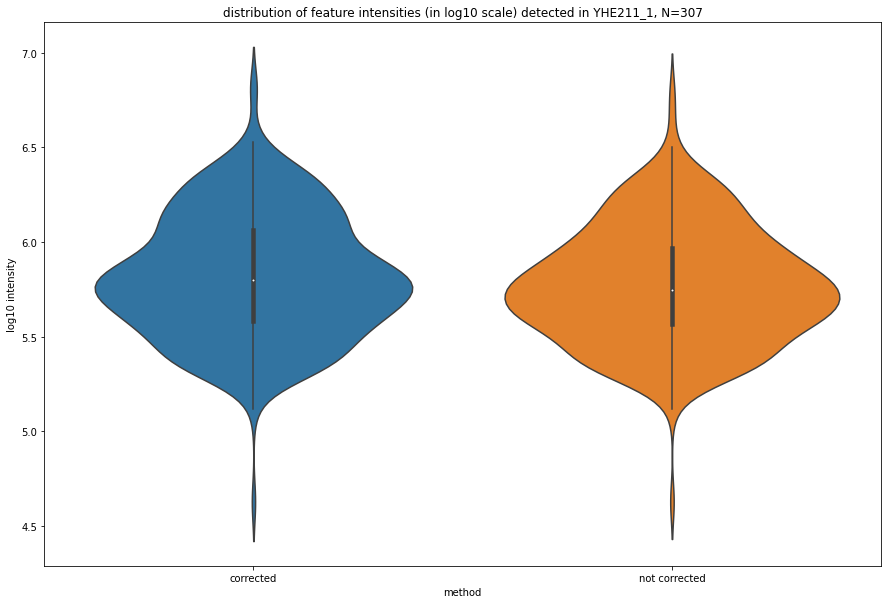

In [51]:
plt.figure(figsize=(15,10))
ax = sns.violinplot(x=adj_df.method, y=adj_df.intensity_log)
_ = plt.ylabel("log10 intensity")
_ = plt.title('distribution of feature intensities (in log10 scale) detected in YHE211_1, N={}'.format(len(adj_with_cs_df)))

#### which isotope was used as a reference for intensity?

In [25]:
isotope_idxs_l = []
for row in adj_with_cs_df.itertuples():
    isotopes_df = pd.DataFrame(row.isotopic_peaks)
    nonsat_isotope_idx = isotopes_df[isotopes_df.inferred == False].iloc[0].name
    isotope_idxs_l.append({'isotope_idx_not_in_saturation':nonsat_isotope_idx})
isotope_idxs_df = pd.DataFrame(isotope_idxs_l)

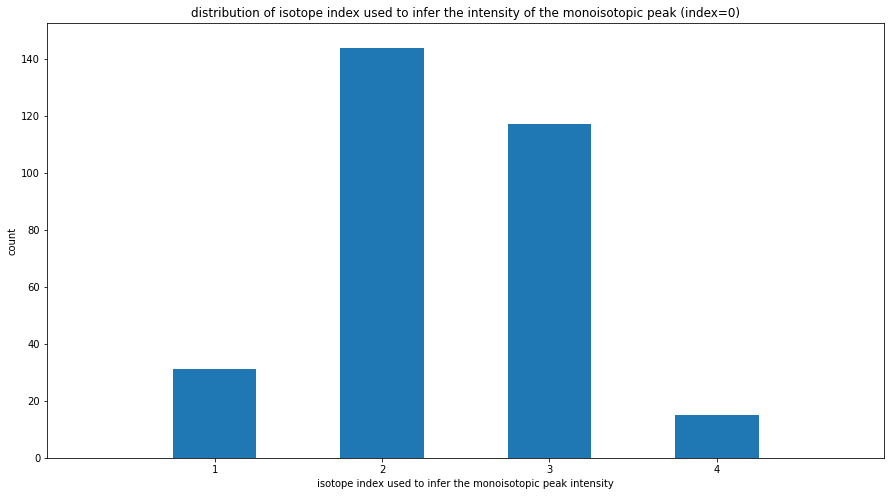

In [26]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

counts = np.bincount(isotope_idxs_df.isotope_idx_not_in_saturation)
ax1.bar(range(isotope_idxs_df.isotope_idx_not_in_saturation.max()+1), counts, width=0.5, align='center')
ax1.set(xticks=range(1,isotope_idxs_df.isotope_idx_not_in_saturation.max()+1), xlim=[0, isotope_idxs_df.isotope_idx_not_in_saturation.max()+1])

plt.xlabel('isotope index used to infer the monoisotopic peak intensity')
plt.ylabel('count')
plt.title('distribution of isotope index used to infer the intensity of the monoisotopic peak (index=0)')

plt.show()

#### of the features that were downgraded, which isotope was used as a reference?

In [27]:
# which sequences had their intensity adjusted down?
downgraded_df = identifications_with_cs_df[(identifications_with_cs_df.mono_intensity_with_saturation_correction < identifications_with_cs_df.mono_intensity_without_saturation_correction)]


In [28]:
isotope_idxs_l = []
for row in downgraded_df.itertuples():
    isotopes_df = pd.DataFrame(row.isotopic_peaks)
    nonsat_isotope_idx = isotopes_df[isotopes_df.inferred == False].iloc[0].name
    isotope_idxs_l.append({'isotope_idx_not_in_saturation':nonsat_isotope_idx})
isotope_idxs_df = pd.DataFrame(isotope_idxs_l)

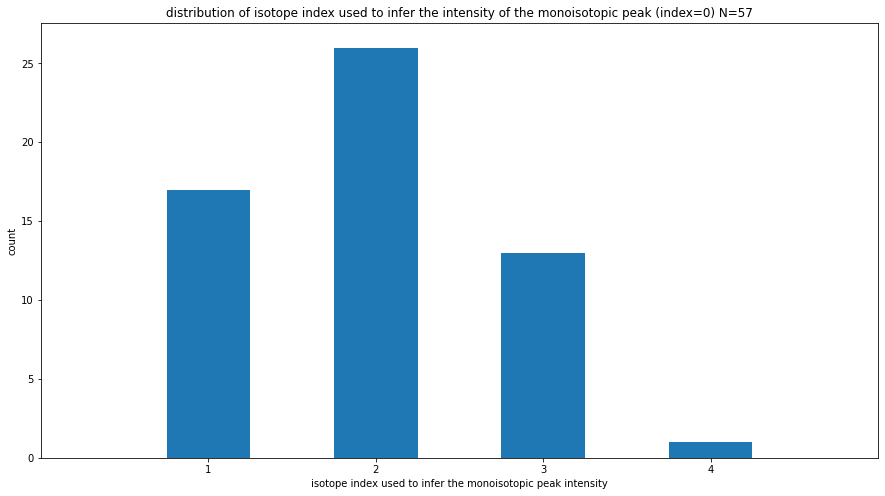

In [29]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

counts = np.bincount(isotope_idxs_df.isotope_idx_not_in_saturation)
ax1.bar(range(isotope_idxs_df.isotope_idx_not_in_saturation.max()+1), counts, width=0.5, align='center')
ax1.set(xticks=range(1,isotope_idxs_df.isotope_idx_not_in_saturation.max()+1), xlim=[0, isotope_idxs_df.isotope_idx_not_in_saturation.max()+1])

plt.xlabel('isotope index used to infer the monoisotopic peak intensity')
plt.ylabel('count')
plt.title('distribution of isotope index used to infer the intensity of the monoisotopic peak (index=0) N={}'.format(len(downgraded_df)))

plt.show()